# Genre Classification Project
The following notebook contains the code used for data collection, preparation, and model creation for music genre classification

# 1) Import dependencies
For the dataset we will use Kaggle. In order to collect that data we need to download it with the Kagglehub library and read the CSV file with the pandas library. For linear algebra, we will use the NumPy library and model creation with the TensorFlow library. Other libraries we use are from Scikit-learn for data normalization, splitting training and testing data, and performance metrics display (confusion matrix).

In [ ]:
import kagglehub
import tensorflow as tf
import tensorflow.keras as keras
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score
import pandas as pd
import numpy as np

In [ ]:
# # Download the dataset from Kaggle
path = kagglehub.dataset_download("harish24/music-genre-classification") + "/dataset.csv"
data = pd.read_csv(path)
data.head()

,filename,chroma_stft,rmse,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,...,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,label
0,blues.00000.wav,0.349943,0.130225,1784.420446,2002.650192,3806.485316,0.083066,-113.596748,121.557297,-19.158825,...,8.810669,-3.667368,5.751691,-5.162763,0.750948,-1.691938,-0.409953,-2.300209,1.219929,blues
1,blues.00001.wav,0.340983,0.095918,1529.835316,2038.617579,3548.820207,0.056044,-207.556793,124.006721,8.930560,...,5.376803,-2.239120,4.216963,-6.012273,0.936110,-0.716537,0.293876,-0.287431,0.531573,blues
2,blues.00002.wav,0.363603,0.175573,1552.481958,1747.165985,3040.514948,0.076301,-90.754387,140.459900,-29.109968,...,5.789265,-8.905224,-1.083720,-9.218359,2.455806,-7.726901,-1.815723,-3.433434,-2.226821,blues
3,blues.00003.wav,0.404779,0.141191,1070.119953,1596.333948,2185.028454,0.033309,-199.431152,150.099213,5.647593,...,6.087677,-2.476421,-1.073890,-2.874778,0.780977,-3.316932,0.637982,-0.619690,-3.408233,blues
4,blues.00004.wav,0.308590,0.091563,1835.494603,1748.362448,3580.945013,0.101500,-160.266037,126.198807,-35.605450,...,-2.806384,-6.934123,-7.558618,-9.173553,-4.512165,-5.453538,-0.924161,-4.409333,-11.703781,blues


# 2) Data processing

In order to make our data usable for the model, we need to extract its input features.
In the CSV file, we don't need the name of the file. We also don't need the labels but we do need them as they are our identification classes.

In [ ]:
# Grab features and normalize them
X = data.drop(['filename', 'label'], axis=1).values
X = StandardScaler().fit_transform(X)
X = X[..., np.newaxis]

# Grab labels and convert them into integer ids
labels = data.iloc[:, -1].values
y = LabelEncoder().fit_transform(labels)

label_dict = data['label'].unique()
label_dict

array(['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz',
       'metal', 'pop', 'reggae', 'rock'], dtype=object)

# 3) Data splitting
There are a total of 1000 samples in our dataset. We need to split these samples into smaller sets for training, testing and validation.

In [ ]:
# Prepare training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=84)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.2, random_state=23)

X_train.shape, y_train.shape

((600, 26, 1), (600,))

# 4) Model creation/compilation
For audio classification, we can use convolutional layers. Here we put in 3 layers of one-dimensional convolutional and max-pooling layers. Then, we flatten the result and dense it into 10 outputs, corresponding with our labels.

In [ ]:
input_shape = (X_train.shape[1], X_train.shape[2])

model = keras.Sequential()

model.add(keras.layers.Conv1D(16, kernel_size=3, activation='relu', strides=1, padding='same', input_shape=input_shape))
model.add(keras.layers.MaxPooling1D(pool_size=2))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Conv1D(32, kernel_size=3, activation='relu', strides=1, padding='same'))
model.add(keras.layers.MaxPooling1D(pool_size=2))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(64, activation='relu'))
model.add(keras.layers.Dense(32, activation='relu'))
model.add(keras.layers.Dense(10, activation='softmax'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
# model.summary()
history = model.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_validation, y_validation))

test_loss, test_acc = model.evaluate(X_test, y_test)

print("Loss: ", test_loss)
print("Accuracy: ", test_acc)

Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.1237 - loss: 2.7394 - val_accuracy: 0.1933 - val_loss: 2.2744
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.2750 - loss: 2.1809 - val_accuracy: 0.2533 - val_loss: 2.2395
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.3293 - loss: 1.8933 - val_accuracy: 0.3000 - val_loss: 2.1981
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4195 - loss: 1.7638 - val_accuracy: 0.3267 - val_loss: 2.1491
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4197 - loss: 1.6438 - val_accuracy: 0.3467 - val_loss: 2.1013
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4335 - loss: 1.5702 - val_accuracy: 0.3600 - val_loss: 2.0526
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4390 - loss: 1.5618 - val_accuracy: 0.3600 - val_loss: 2.0012
Epoch 8/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5040 - loss: 1.4304 - val_accuracy: 0.406

# 5) Performance evaluation
(See report for analysis)

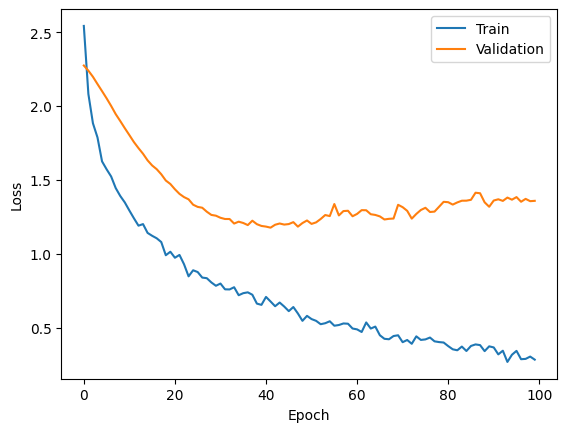

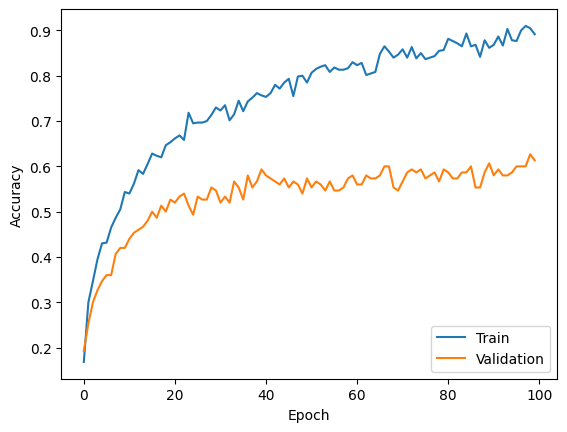

In [ ]:
# Plot model accuracy and loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

In [ ]:
true = []
pred = []

# Predictions
for i in range(10):
    X_predict = X_test[i]
    y_predict = y_test[i]

    X_predict = X_predict[np.newaxis, ...]

    prediction = model.predict(X_predict)
    predicted_ind = np.argmax(prediction, axis=1)

    print(f"Target: {label_dict[y_predict]}\nPredicted: {label_dict[predicted_ind]}")

    true.append(label_dict[y_predict])
    pred.append(label_dict[predicted_ind])

cm = confusion_matrix(true, pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
Target: rock
Predicted: ['jazz']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Target: pop
Predicted: ['pop']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Target: hiphop
Predicted: ['metal']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Target: metal
Predicted: ['metal']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Target: disco
Predicted: ['disco']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Target: country
Predicted: ['reggae']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Target: hiphop
Predicted: ['disco']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Target: blues
Predicted: ['blues']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Target: classical
Predicted: ['classical']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Target: reggae
Predicted: ['hiphop']


[[1 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0]
 [0 0 0 1 0 0 0 0 0 0]
 [0 0 0 1 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0]]
f1 Score: 0.5


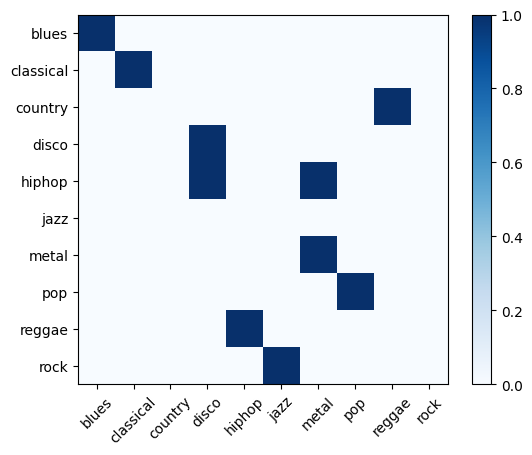

In [ ]:
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(label_dict))
plt.xticks(tick_marks, label_dict, rotation=45)
plt.yticks(tick_marks, label_dict)

print(cm)

f1 = f1_score(true, pred, average='micro')

print(f"f1 Score: {f1}")